## __인구수 가중치 계산 방법__

----------------------------------------------------------------------
### __Intro__
* 본 ipynb는 집계구 단위로 제공되는 서울시 생활 인구 데이터 전처리 과정을 시각화하는데 목적이 있습니다.
* 실제 가중치 파일을 추출하기 위해서는 같은 경로 내 존재하는 Caculate_TOT_weight.py를 활용하면 됩니다.
* 가중치 계산을 위한 shp파일은 공식 깃허브에서 제공합니다.

### __사용 데이터__
* 실시간 도시 데이터 집계 범위: https://data.seoul.go.kr/dataList/OA-21778/A/1/datasetView.do
* 생활 인구 데이터 집계 범위(집계구): https://data.seoul.go.kr/dataList/OA-14979/S/1/datasetView.do#

### __목적__
* 생활 인구 데이터 기반 지하철 역 유동인구 추정을 위한 공간적 가중치 계산

### __필요성__
* CamelNeon은 서울시에서 제공하는 실시간 도시 데이터(이하, rp)로부터, 지하철 역 내 유동인구 데이터를 수집함.
  * 그러나, rp는 과거 기록을 제공하지 않아 타 데이터와 비교가 불가능함
  * 또한, 유동인구 예측 모델 개발 등 타 개발로 확장이 어려움
* 같은 서울시에서 제공하는 생활 인구 데이터(이하, lp)는 과거 데이터를 제공함.
  * 그러나, 집계구 단위로 제공하기에 본 프로젝트(CamelNeon)에 적용하기 어려움
* 따라서, 본 ipynb는 두 데이터 간 집계 범위를 공간적으로 분석하여, lp의 집계구 별 가중치를 계산하는 방법을 개발하였으며 이를 소개하고자함

### 구조
* shape: 각 데이터 집계 범위 shp 파일이 저장된 폴더
* 인구수 가중치 계산 과정.ipynb: 공간 분석을 통해 가중치를 구하는 과정을 시각화하고 설명하는 코드
* Cacluate_TOT_weight.py: 가중치 계산을 수행하는 python script
* TOT_weight.py:  인구수 가중치를 계산해주는 python scripy

In [1]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import koreanize_matplotlib

### __1. RP 데이터의 집계 범위 데이터 불러오기__

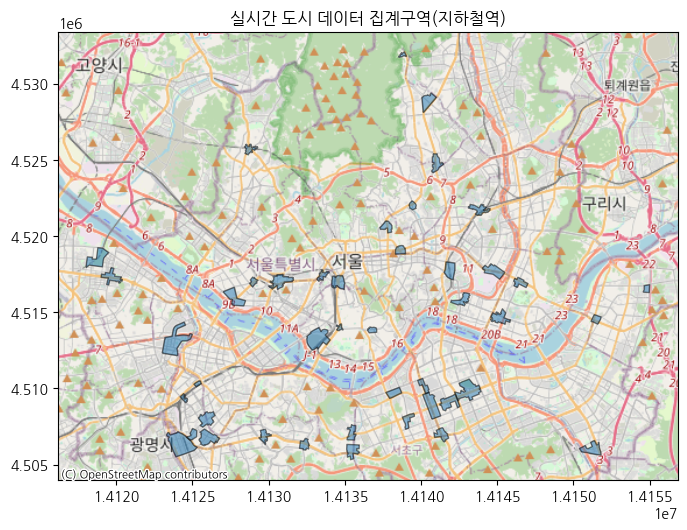

In [2]:
rp_gdf = gpd.read_file('./shape/실시간 도시 데이터 집계구역.shp')
rp_gdf = rp_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(8, 6))
rp_gdf.plot(ax=ax, edgecolor="black", alpha=0.5, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("실시간 도시 데이터 집계구역(지하철역)")
plt.show()

In [3]:
rp_gdf.head()

,CATEGORY,AREA_CD,AREA_NM,geometry
0,인구밀집지역,POI013,가산디지털단지역,"POLYGON ((14123479.946 4506566.907, 14123460.4..."
1,인구밀집지역,POI014,강남역,"POLYGON ((14140721.231 4507982.119, 14140660.3..."
2,인구밀집지역,POI015,건대입구역,"POLYGON ((14145376.267 4515179.281, 14145408.7..."
3,인구밀집지역,POI016,고덕역,"POLYGON ((14154642.022 4516473.69, 14154644.50..."
4,인구밀집지역,POI017,고속터미널역,"POLYGON ((14138637.373 4509934.307, 14138646.6..."


### __2. RP 데이터의 집계 범위 데이터 불러오기__
* LP 데이터 집계 범위 불러오기
* LP 데이터의 집계구 별 면적 계산

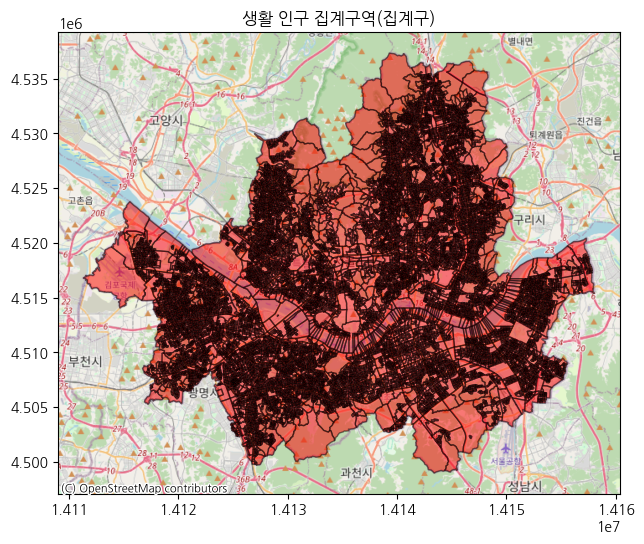

In [4]:
lp_gdf = gpd.read_file('./shape/집계구.shp')
lp_gdf = lp_gdf.to_crs(epsg=3857)
lp_gdf['area_total'] = lp_gdf.geometry.area
fig, ax = plt.subplots(figsize=(8, 6))
lp_gdf.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("생활 인구 집계구역(집계구)")
plt.show()

In [5]:
lp_gdf.head()

,TOT_REG_CD,ADM_NM,ADM_CD,REG_AREA,geometry,area_total
0,1101053010006,사직동,1101053,18424.35,"POLYGON ((14134272.82 4520138.849, 14134279.43...",29384.810435
1,1101053010001,사직동,1101053,18820.71,"POLYGON ((14133805.368 4519554.335, 14133826.3...",30013.644437
2,1101053010003,사직동,1101053,218981.33,"POLYGON ((14133840.887 4520097.627, 14133843.1...",349234.479170
3,1101053010002,사직동,1101053,37081.81,"POLYGON ((14134099.332 4520013.914, 14134099.9...",59139.492566
4,1101053010005,사직동,1101053,70995.58,"POLYGON ((14134679.424 4520014.38, 14134681.14...",113229.304750


### 3. 두 shp 데이터 간 교차영역 계산 후 각 지하철 역 별 가중치 계산
* 교차영역 계산
* 교차영역 별 면적 계산
* 교차영역 면적/집계구 면적으로 각 영역 별 가중치 계산

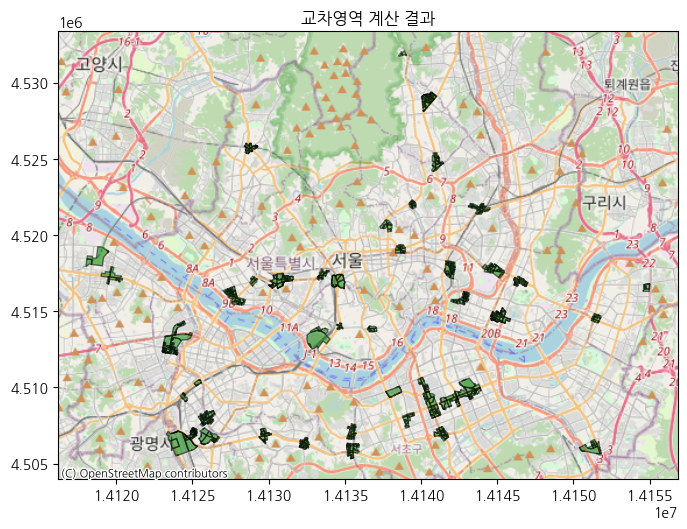

In [6]:
intersection = gpd.overlay(rp_gdf, lp_gdf, how='intersection', keep_geom_type=True)
intersection['area_section'] = intersection.geometry.area
intersection['rate'] = intersection['area_section']/intersection['area_total']
fig, ax = plt.subplots(figsize=(8, 6))
intersection.plot(ax=ax, color="green", edgecolor="black", alpha=0.5, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("교차영역 계산 결과")
plt.show()

In [7]:
intersection.head()

,CATEGORY,AREA_CD,AREA_NM,TOT_REG_CD,ADM_NM,ADM_CD,REG_AREA,area_total,geometry,area_section,rate
0,인구밀집지역,POI013,가산디지털단지역,1118051010001,가산동,1118051,23090.98,3.673427e+04,"POLYGON ((14124685.199 4506744.53, 14124692.02...",3.673024e+04,0.999890
1,인구밀집지역,POI013,가산디지털단지역,1118051010003,가산동,1118051,215886.15,3.434152e+05,"POLYGON ((14124778.484 4506664.885, 14124781.0...",3.433920e+05,0.999932
2,인구밀집지역,POI013,가산디지털단지역,1118051010002,가산동,1118051,15779.28,2.510286e+04,"POLYGON ((14124581.786 4506836.533, 14124587.8...",2.510087e+04,0.999921
3,인구밀집지역,POI013,가산디지털단지역,1118051010004,가산동,1118051,18596.58,2.958566e+04,"POLYGON ((14124339.555 4507018.204, 14124351.4...",2.958392e+04,0.999941
4,인구밀집지역,POI013,가산디지털단지역,1118051020002,가산동,1118051,736729.26,1.171967e+06,"POLYGON ((14123460.465 4506547.548, 14123458.7...",1.171929e+06,0.999967


In [8]:
# 필요한 데이터만 저장
final_df = intersection[['AREA_NM', 'TOT_REG_CD', 'ADM_NM', 'rate']]
final_df.to_csv('Rate.csv', index=0)